# Eyes and Lips Segmentation with UNet implemented from scratch

## Imports

In [ ]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from PIL import Image
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm.notebook import tqdm
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch.autograd import Variable

## Data Preprocessing

The 4 different channels for each image (left eye, right eye, upper lip and lower lip) given in the dataset are combined into one black and white image of (512, 512) size in the script `make_masks.py`. Run this script locally once you have unzipped CelebMask-HQ dataset. Once then the output should look like [this](https://drive.google.com/drive/folders/1-_K1XRGiyYN08LttA7vkyG72Hn1Q-0bt?usp=sharing).

```
import os
import cv2
import numpy as np

label_list = ['l_eye', 'r_eye', 'u_lip', 'l_lip']

folder_base = 'CelebAMask-HQ-mask-anno'
folder_save = 'CelebAMaskHQ-mask'

img_num = 30000

os.chdir(os.path.join(os.getcwd()))

print(os.listdir())


def make_folder(path):
    if not os.path.exists(os.path.join(path)):
        os.makedirs(os.path.join(path))


make_folder(folder_save)

for k in range(img_num):
    # The masks are divided into folders from 0 to 14 therefore this step is to extract the folder number
    folder_num = k // 2000

    # empty image of size 512x512
    im_base = np.zeros((512, 512))

    # make sure that an empty mask image isn't included
    is_empty = True

    for idx, label in enumerate(label_list):
        # depends on the file format CelebAMask-HQ authors chose
        filename = os.path.join(folder_base, str(folder_num), str(
            k).rjust(5, '0') + '_' + label + '.png')

        if os.path.exists(filename.strip(' ')):
            is_empty = False   # means our mask isn't empty
            im = cv2.imread(filename)
            im = im[:, :, 0]
            im_base[im != 0] = 255

    if not is_empty:
        # save as an image
        filename_save = os.path.join(folder_save, str(k) + '.png')
        print(filename_save)
        cv2.imwrite(filename_save, im_base)

```

### Mounting Google Drive to Access Dataset 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
os.chdir('/gdrive/MyDrive/CelebAMask-HQ-Dataset/CelebAMask-HQ')

### Data Augmentation

For the image, we resize the original 512 by 512 image to 572 by 572 (UNet's input size) and for the mask we resize the image to 388 by 388 (UNet's output size). Then we convert them to tensors and normalize the images by applying imagenet stats since our model was also pretrained on ImageNet

In [ ]:
image_transform = transforms.Compose([transforms.Resize((572, 572), 2),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # imagenet stats
        
mask_transform = transforms.Compose([transforms.Resize((388, 388), 2),
                                    transforms.ToTensor()])

The image and mask folders are separated so we extract the list of images in the masks folder, sort them and then make another image list in which we alter the path to represent inputs so we get the correct image corresponding to a mask.
For each image, mask pair -
1. The image is converted to RGB and respective augementations are applied to it.
2. The mask is converted to a single L channel, to be interpreted as grayscale and respective augementations are applied to it.
3. We then obtain, two images from our mask. One which is the original mask and other in which every pixel is reversed (just the opposite).
4. We superimpose these two images to form two channels (image shape : 388x388x2), which is what our model will be predicting.

### Custom Dataset

In [ ]:
class CelebAHQ(Dataset):
    def __init__(self, parent_dir, image_dir, mask_dir, image_transform, mask_transform):

        self.mask_list = glob.glob(parent_dir+'/'+mask_dir+'/*')
        # A smaller subset of 1000 images out of 30000 were chosen to train faster. Change below to add more more data.
        self.mask_list = self.mask_list[:1000]
        self.mask_list.sort()
        self.image_list = []

        # an image exists for every mask
        for path in self.mask_list:
            self.image_list.append(path.replace('.png', '.jpg').replace(mask_dir, image_dir))
        self.mask_list = self.mask_list

        self.image_transform = image_transform
        self.mask_transform = mask_transform
                
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img = Image.open(self.image_list[index]).convert('RGB')
        img = image_transform(img)
        
        mask = Image.open(self.mask_list[index]).convert('L')
        mask_present = mask_transform(mask)

        mask_present = mask_present.type(torch.BoolTensor)
        mask_not_present = torch.bitwise_not(mask_present)
        mask = torch.cat([mask_not_present, mask_present], dim=0)
        
        return img, mask

In [ ]:
# change path according to your need
dataset = CelebAHQ('.', 'CelebA-HQ-img', 'CelebAMaskHQ-mask', image_transform, mask_transform)

In [ ]:
len(dataset)

1000

## Splitting the dataset

The train, validation, test ratios are 0.8, 0.1 and 0.1 of the whole dataset. A batch size of 8 was chosen after experiments with the GPU. Then we make dataloaders for train, test and validation datasets.

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
def train_val_test_split(dataset):
    train_dataset = torch.utils.data.Subset(dataset, range(0, int(0.8 * len(dataset))))
    val_dataset = torch.utils.data.Subset(dataset, range(int(0.8*len(dataset)), int(0.9*len(dataset))))
    test_dataset = torch.utils.data.Subset(dataset, range(int(0.9*len(dataset)), len(dataset)))
    return train_dataset, val_dataset, test_dataset

In [ ]:
batch_size = 8
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, drop_last=True, num_workers=4, pin_memory=True)

In [ ]:
len(train_dataset), len(val_dataset)

(800, 100)

## Using a GPU

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
    # Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Evaluation Metrics

1. Intersection over Union (Jaccard index) is a standard and reliable metric for segmentation tasks. It is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth.

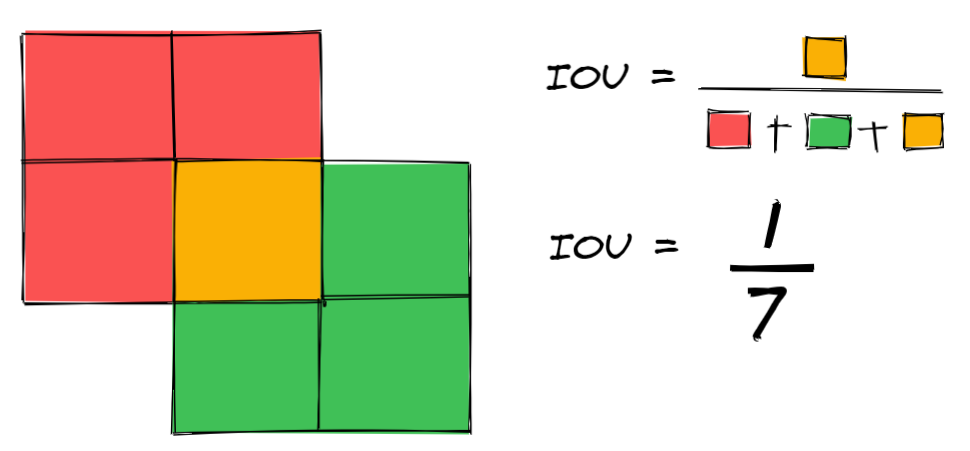

2. Pixel Accuracy is also used to show a contrast with IOU as our positive and negative classes are imbalanced.

In [ ]:
def mean_IOU(target, predicted): 
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

In [ ]:
def pixel_acc(target, predicted):     
    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total
    
    pixel_accuracy = accsum/target.shape[0]        
    return pixel_accuracy

## Model

The UNet architecture is pretty popular for segmentation tasks. We are going to train a UNet model written from scratch. Here is a visual representation of the code -

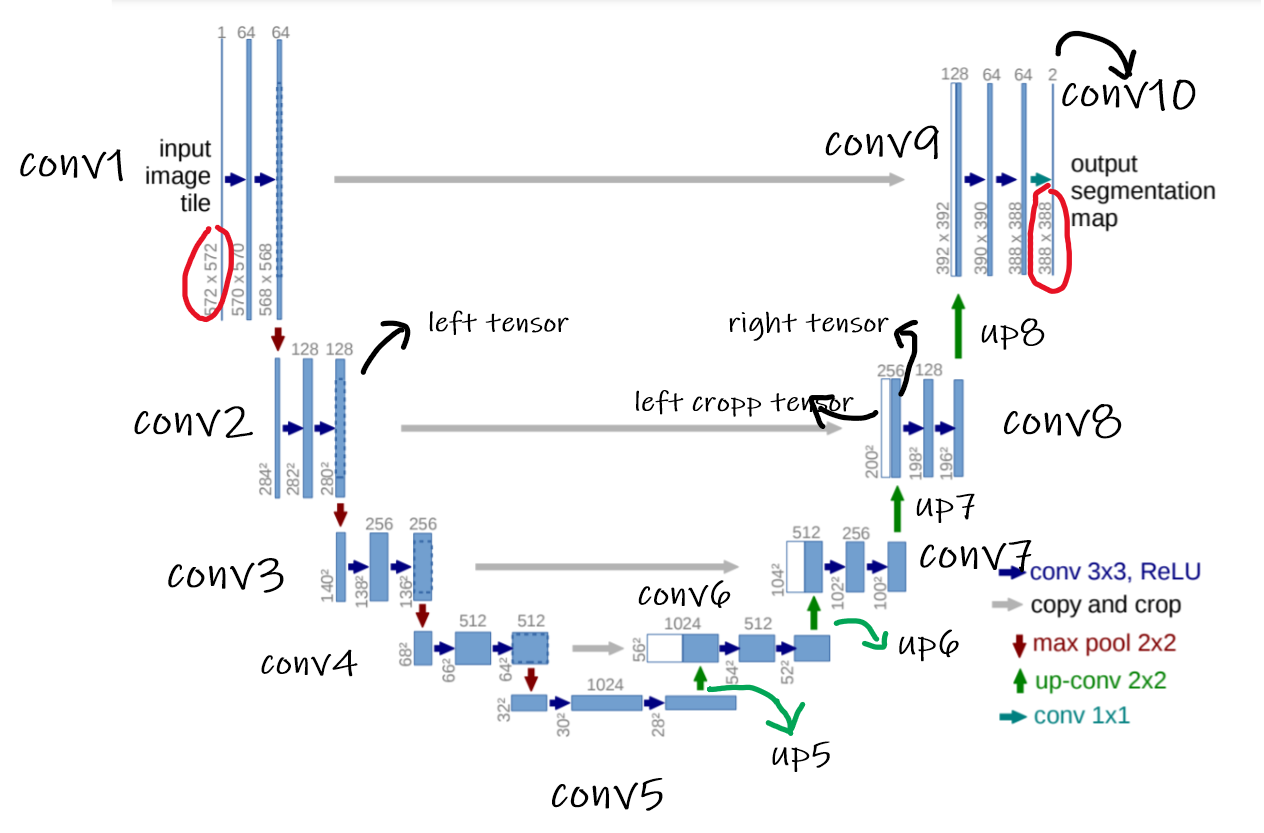

In [ ]:
def conv_block(in_channels, out_channels):
    return nn.Sequential( nn.Conv2d(in_channels, out_channels, kernel_size= 3),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(out_channels, out_channels, kernel_size= 3),
                          nn.ReLU(inplace=True))

def conv_block_down(in_channels, out_channels):   
    return nn.Sequential( nn.MaxPool2d(2, stride=2),
                          nn.Conv2d(in_channels, out_channels, kernel_size= 3),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(out_channels, out_channels, kernel_size= 3),
                          nn.ReLU(inplace=True))

def crop_concatenate(left_tensor, right_tensor):
    left_tensor_size = left_tensor.size()[2]  # To extract height/width
    right_tensor_size = right_tensor.size()[2]

    diff = left_tensor_size - right_tensor_size
    start_crop = diff//2
    end_crop = left_tensor_size - diff//2

    left_tensor = left_tensor[:, :, start_crop: end_crop,  start_crop: end_crop] # Batches : Channels : Height : Width

    return torch.cat((left_tensor, right_tensor), dim=1)  # Superimpose channels of left cropped tensor and right tensor

def upsample(in_channels):
    return nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size= 2, stride= 2)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = conv_block(3, 64)

        self.conv2 = conv_block_down(64, 128)
        self.conv3 = conv_block_down(128, 256)
        self.conv4 = conv_block_down(256, 512)
        self.conv5 = conv_block_down(512, 1024)

        self.up5 = upsample(1024)
        self.conv6 = conv_block(1024, 512)
        self.up6 = upsample(512)
        self.conv7 = conv_block(512, 256)
        self.up7 = upsample(256)
        self.conv8 = conv_block(256, 128)
        self.up8 = upsample(128)
        self.conv9 = conv_block(128, 64)

        self.conv10 = nn.Conv2d(64, 2, 1)

    def forward(self, input):
        out1 = self.conv1(input)

        out2 = self.conv2(out1) 
        out3 = self.conv3(out2) 
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        # Upsample current output -> Crop corresponding left side output and conctenate with current output -> Pass through next layer
        out5 = self.up5(out5)
        out6 = self.conv6(crop_concatenate(out4, out5))
        out6 = self.up6(out6)
        out7 = self.conv7(crop_concatenate(out3, out6))
        out7 = self.up7(out7)
        out8 = self.conv8(crop_concatenate(out2, out7))
        out8 = self.up8(out8)
        out9 = self.conv9(crop_concatenate(out1, out8))

        output = self.conv10(out9)
        return output

In [ ]:
model = UNet()
to_device(model, device)

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(512, 

## Hyperparameters

1. Adam optimizer is one of the most commonly used optimizers used in context of image segmentation networks and therefore I chose Adam.
2. Since we have black and white masks, a binary segmentation task, BCEWithLogitsLoss was the apporopriate loss function.
3. An Exponential LR Schedular works as good as a step decay one, so I went with that.

A higher learning rate in the beginning was chosen as we are training from scratch and then decreased by 10%.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

## Training loop

Checkpoints are used since a single epoch took considerable time and progress could easily be tracked using them. We just load a previous checkpoint if available else we train from from scratch. 
- Training Phase. For a batch in train_loader :

  1. Generate predictions
  2. Calculate loss
  3. Compute gradients
  4. Update weights
  5. Reset gradients
- Validation Phase. For batch in val_loader:

  1. Generate predictions
  2. Calculate loss
  3. Calculate error metrics

  After which we save the checkpoint file.

In [ ]:
def fit(epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader, last_ckpt_path = None):   
    tr_loss_arr = []
    val_loss_arr = []
    meanioutrain = []
    pixelacctrain = []
    meanioutest = []
    pixelacctest = []
    prev_epoch = 0
    
    if last_ckpt_path != None :
        checkpoint = torch.load(last_ckpt_path)
        prev_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = to_device(v, device)
                    tr_loss_arr =  checkpoint['Training Loss']
        val_loss_arr =  checkpoint['Validation Loss']
        meanioutrain =  checkpoint['MeanIOU train']
        pixelacctrain =  checkpoint['PixelAcc train']
        meanioutest =  checkpoint['MeanIOU test']
        pixelacctest =  checkpoint['PixelAcc test']
        to_device(model, device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        pixelacc = 0
        meaniou = 0
        
        pbar = tqdm(train_loader, total = len(train_loader))
        for input, mask in pbar:
            torch.cuda.empty_cache()
            model.train()
            input = input.float()
            mask = mask.float()
            pred = model(input)
            loss = loss_fn(pred, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tr_loss_arr.append(loss.item())
            meanioutrain.append(mean_IOU(mask, pred))
            pixelacctrain.append(pixel_acc(mask, pred))
            pbar.set_postfix({'Epoch':epoch+1+prev_epoch, 
                              'Training Loss': np.mean(tr_loss_arr),
                              'Mean IOU': np.mean(meanioutrain),
                              'Pixel Acc': np.mean(pixelacctrain)})
            
        with torch.no_grad():
            
            val_loss = 0
            pbar = tqdm(val_loader, total = len(val_loader))
            for input, mask in pbar:
                torch.cuda.empty_cache()
                input = input.float()
                mask = mask.float()
                model.eval()
                pred = model(input)
                
                val_loss_arr.append(loss_fn(pred, mask).item())
                pixelacctest.append(pixel_acc(mask, pred))
                meanioutest.append(mean_IOU(mask, pred))
                
                pbar.set_postfix({'Epoch':epoch+1+prev_epoch, 
                                  'Validation Loss': np.mean(val_loss_arr),
                                  'Mean IOU': np.mean(meanioutest),
                                  'Pixel Acc': np.mean(pixelacctest)
                                 })
        
        checkpoint = {
            'epoch':epoch+1+prev_epoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'MeanIOU train':meanioutrain, 
            'PixelAcc train':pixelacctrain, 
            'MeanIOU test':meanioutest, 
            'PixelAcc test':pixelacctest
        }
        torch.save(checkpoint, f"{epoch+1+prev_epoch}.pth")
        lr_scheduler.step()
        
    return tr_loss_arr, val_loss_arr, meanioutrain, pixelacctrain, meanioutest, pixelacctest

In [ ]:
retval = [fit(10, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader)]

In [84]:
retval += [fit(10, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader, '30.pth')]

After training for 40 epochs, here is the inference.

## Testing the Model

In [85]:
# Loading the model and weights and setting it in evaluation mode
def load_checkpoint(path): 
    model = DeepLabv3()
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

In [86]:
def get_prediction(path_img, path_model):
    img = Image.open(path_img)
    
    transform = transforms.Compose([transforms.Resize((572, 572), 2),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # imagenet stats
    input_img = transform(img)
    with torch.no_grad():
        #model = to_device(load_checkpoint(path_model), device)
        input_img = to_device(input_img, device).float()
        ytest = model(input_img.unsqueeze(0).float())
        ypos = ytest[0, 1, :, :].clone().detach().cpu().numpy() # positive segmentation mask
        yneg = ytest[0, 0, :, :].clone().detach().cpu().numpy() # negative segmentation mask
        ytest = ypos >= yneg  # combining both
    
    mask = ytest.astype('float32')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.dilate(mask,kernel,iterations = 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

In [87]:
def get_mask_on_image(image, mask):
    color_mask = np.zeros_like(image)
    color_mask[:, :, 1] += mask.astype('uint8') * 250
    masked = cv2.addWeighted(image, 0.5, color_mask, 0.5 ,0.0)
    return masked

In [88]:
def print_prediction(path_img,path_model):
    img = cv2.imread(path_img)
    img = cv2.resize(img, (388, 388))
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = get_prediction(path_img, path_model)

    mask_on_img = get_mask_on_image(rgb_img, mask)

    fig = plt.figure()
    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(rgb_img)
    a.set_title('Input')
    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(mask)
    a.set_title('Output')
    a = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(mask_on_img)
    a.set_title('Output')

In [89]:
@torch.no_grad()
def get_test_score(test_loader):
    val_loss = 0
    val_loss_arr = []
    pixelacctest = []
    meanioutest = []
    pbar = tqdm(val_loader, total = len(val_loader))
    for input, mask in pbar:
        torch.cuda.empty_cache()
        input = input.float()
        mask = mask.float()
        model.eval()
        pred = model(input)
        
        val_loss_arr.append(loss_fn(pred, mask).item())
        pixelacctest.append(pixel_acc(mask, pred))
        meanioutest.append(mean_IOU(mask, pred))
        
        pbar.set_postfix({'Validation Loss': np.mean(val_loss_arr),
                          'Mean IOU': np.mean(meanioutest),
                          'Pixel Acc': np.mean(pixelacctest)
                          })

### Results on Unseen Data

In [90]:
get_test_score(test_loader)

### Printing few Examples

In [91]:
def get_example_preds(base_file_path, model_path):
    for i in range(3):
        print_prediction(f"{base_file_path}/{i}.jpg", model_path)

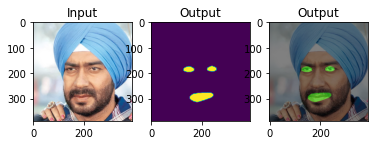

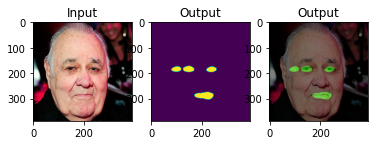

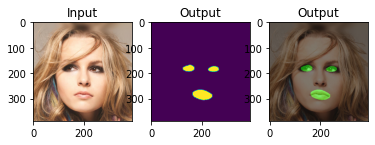

In [94]:
get_example_preds('test-images', 'model_unet.pth')